In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization ,Dropout
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K

from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz


c:\users\cristi\pycharmprojects\x_ray\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos]


print(get_available_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13785272660887095040
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1933094912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18286239690777651372
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'), #true-positive
    tf.keras.metrics.FalsePositives(name='fp'), #false-positive
    tf.keras.metrics.TrueNegatives(name='tn'), #true-negative
    tf.keras.metrics.FalseNegatives(name='fn'), #false-negative
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'), 
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [4]:
img_width, img_height = 150, 150
batch_size = 10
epochs = 200
COUNT_NORMAL_TRAIN = 1342
COUNT_PNEUMONIA_TRAIN = 3876
TRAIN_IMAGE_COUNT = COUNT_NORMAL_TRAIN + COUNT_PNEUMONIA_TRAIN
weight_for_0 = (1 / COUNT_NORMAL_TRAIN) * (TRAIN_IMAGE_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA_TRAIN) * (TRAIN_IMAGE_COUNT) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0)) #1.94
print('Weight for class 1: {:.2f}'.format(weight_for_1)) #0.67

Weight for class 0: 1.94
Weight for class 1: 0.67


In [5]:
if K.image_data_format() == "channels_first":
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [6]:
def build_model_densenet():
    model_densenet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        classes=1
    )

    for layer in model_densenet.layers[:-8]:
        layer.trainable = False

    for layer in model_densenet.layers[-8:]:
        layer.trainable = True

    model = tf.keras.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=input_shape),
            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
            tf.keras.layers.experimental.preprocessing.RandomZoom(
                height_factor=0.2,
                width_factor=0.2,
            ),
            model_densenet,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ]
    )

    return model

In [7]:
model = build_model_densenet()

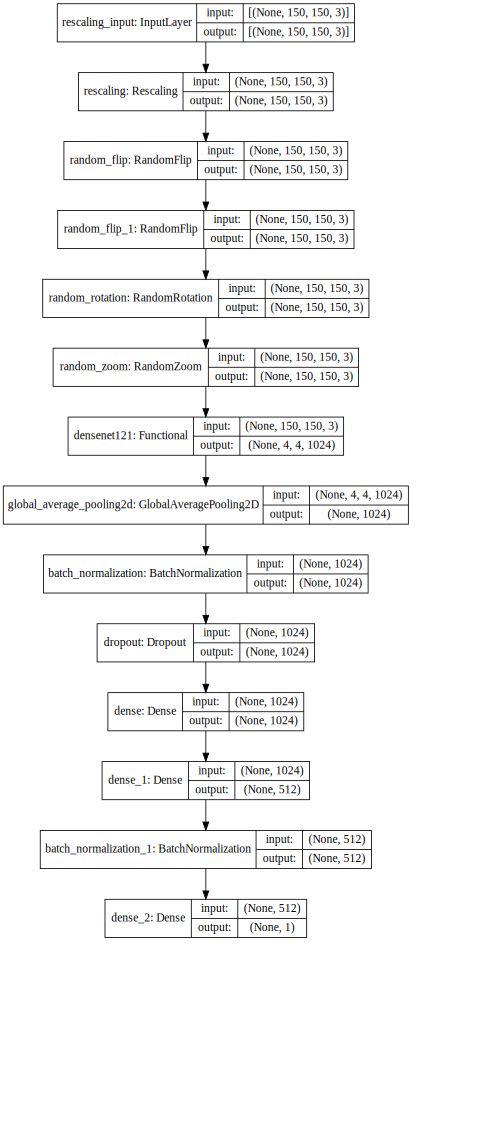

In [9]:
SVG(model_to_dot(
    model, show_shapes=True, show_layer_names=True, rankdir='TB',
    expand_nested=False, dpi=60, subgraph=False
).create(prog='dot',format='svg'))


In [8]:
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        #       y_true_K = tf.ones_like(y_true)
        focal_loss = fl(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
        return focal_loss

    return binary_focal_loss

In [9]:
model.compile(
    optimizer='adam',
    #     loss='binary_crossentropy',
    #     loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2,gamma=2.0),
    loss=focal_loss_custom(gamma=2.0, alpha=0.2),
    metrics=METRICS
)

In [11]:
model.load_weights('./models/Dense121FocalLossAdam89perc/')

In [15]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/test/',
    labels='inferred',
    batch_size=1,
    #     seed=123,
    #     subset='training',
    #     validation_split=0.2
    image_size=(img_height, img_width)
)
AUTOTUNE = tf.data.AUTOTUNE

test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 624 files belonging to 2 classes.


In [16]:
eval_history = model.evaluate(
    test_ds,
    batch_size=1,
)

624/624 [==============================] - 24s 29ms/step - loss: 0.0276 - tp: 328.0000 - fp: 13.0000 - tn: 221.0000 - fn: 62.0000 - accuracy: 0.8798 - precision: 0.9619 - recall: 0.8410 - auc: 0.9660 - prc: 0.9727


In [34]:
test_img = tf.keras.preprocessing.image.load_img(
    '../chest_xray/chest_xray/test/NORMAL/IM-0003-0001.jpeg',
    #     '../chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg',
    target_size=(img_width, img_height),
)
input_arr = tf.keras.preprocessing.image.img_to_array(test_img)
input_arr = np.array([input_arr])

In [35]:
predictions = model.predict(input_arr)
predictions

array([[0.10002454]], dtype=float32)